In [2]:
using DataFrames, CSV, DelimitedFiles

CODE_ROOT = pwd() * "/../.."

include(CODE_ROOT * "/visualization.jl")

vertexHeatMapMesh (generic function with 1 method)

In [3]:
function latestfile(dir, filterfunc)
    return filter(filterfunc, readdir(dir, join=true))[end]
end

latestfile (generic function with 1 method)

In [4]:
using Statistics

In [5]:
nCellsX = 128
jprocs = 2048
fprocs = 2048

2048

In [6]:
fname = latestfile(CODE_ROOT * "/output/kelvinwave/resolution$(nCellsX)x$(nCellsX)/procs$(jprocs)/steps10/nvlevels100/", x->x[end-3:end] == ".txt")
# fname *= "2022-08-24T16:27:20.125.txt"
# fname *= "2022-08-24T16:40:29.640.txt"
# "/output/kelvinwave/resolution$(nCellsX)x$(nCellsX)/steps10/2022-06-01T20:17:04.919.txt"
df = DataFrame(CSV.File(fname))

runs = filter(col->startswith(col,"sim_time"), names(df))[2:end]
mpis = filter(col->startswith(col,"mpi_time"), names(df))[2:end]
juliasimmean = 1/length(runs) * sum(Array(df[:,runs]), dims=2)
juliampimean = 1/length(mpis) * sum(Array(df[:,mpis]), dims=2)
juliameans = juliasimmean .+ juliampimean


fortranfname = latestfile(CODE_ROOT * "/output/kelvinwave/fortranperformance/resolution$(nCellsX)x$(nCellsX)/", x -> occursin("$fprocs", x) && x[end-3:end] == ".txt")
fortrantiming = readdlm(fortranfname, skipstart=7)
fortranmeans = fortrantiming[:,end-2] #./ 4
fortranprocs = fortrantiming[:,1]

juliasimstd = std(Array(df[:,runs]), dims=2)
juliampistd = std(Array(df[:,mpis]), dims=2)

11×1 Matrix{Float64}:
 0.10050457983215881
 0.17102857047258246
 0.10792559314379743
 0.06582424414661761
 0.083853739777414
 0.08968659833544454
 0.13930942117270478
 0.13232062253350493
 0.1555744335738639
 0.08635576232971547
 0.04187143712451439

In [7]:
df

Row,procs,sim_time1,sim_time2,sim_time3,sim_time4,sim_time5,sim_time6,sim_time7,sim_time8,sim_time9,sim_time10,sim_time11,sim_time12,mpi_time1,mpi_time2,mpi_time3,mpi_time4,mpi_time5,mpi_time6,mpi_time7,mpi_time8,mpi_time9,mpi_time10,mpi_time11,mpi_time12,max_error,l2_error
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,2.0,4.09977,3.96398,3.8511,4.11677,3.8368,3.8554,3.84816,3.84601,3.85446,3.81535,3.88046,3.82353,3.40134,0.017575,0.356201,0.0141014,0.0677649,0.0469985,0.00808844,0.0385784,0.00822951,0.0701561,0.0101769,0.0329462,0.000332521,0.000115771
2,4.0,1.86487,1.88423,1.90479,1.92981,1.87833,1.90547,1.90868,1.92887,1.88613,1.9076,1.90671,1.8844,7.40309,0.576282,0.106019,0.0817078,0.129831,0.0641163,0.429572,0.0798951,0.0745096,0.128083,0.0426409,0.158312,0.000337382,0.000157937
3,8.0,0.90079,0.924718,0.886215,0.891947,0.902605,0.910494,0.910705,0.94302,0.88592,0.891801,0.910053,0.910057,7.45681,0.117926,0.272771,0.20573,0.128359,0.197355,0.187649,0.142184,0.50199,0.134293,0.209493,0.174514,2.43411e-5,4.44424e-6
4,16.0,0.501596,0.467885,0.465657,0.47167,0.474364,0.475557,0.482888,0.482107,0.523863,0.908341,0.544022,0.465663,7.38207,0.239991,0.109293,0.130408,0.109702,0.194231,0.244326,0.0699888,0.0984383,0.0416683,0.175395,0.136713,0.000426889,0.000168255
5,32.0,0.247024,0.251525,0.248272,0.252879,0.246241,0.246113,0.256237,0.250821,0.25676,0.253932,0.252281,0.272505,7.51884,0.131658,0.328192,0.193542,0.0945968,0.0634947,0.0757414,0.109053,0.120021,0.267938,0.103458,0.106466,1.06922e-5,3.50938e-6
6,64.0,0.14433,0.14924,0.14877,0.148617,0.147187,0.147796,0.147805,0.14843,0.146011,0.147127,0.140777,0.146634,8.17343,0.0779667,0.0604032,0.151005,0.210618,0.27163,0.270258,0.0355759,0.0442515,0.075709,0.215962,0.172691,1.00266e-5,2.60362e-6
7,128.0,0.0794964,0.0737099,0.0737715,0.0862065,0.0757997,0.0763285,0.0760664,0.076577,0.0765855,0.0756355,0.0751575,0.0752872,8.17717,0.0347929,0.0427127,0.0744643,0.0203871,0.0196949,0.0435291,0.221263,0.437211,0.172048,0.322626,0.183998,1.37755e-5,3.75396e-6
8,256.0,0.044511,0.0432451,0.0433812,0.0433764,0.0429102,0.0430326,0.0432838,0.0431974,0.0430605,0.042676,0.0428824,0.0434261,8.40579,0.135572,0.253104,0.323589,0.0449109,0.0575676,0.316127,0.0350268,0.0280245,0.0245443,0.0593622,0.337058,1.00929e-5,4.35622e-6
9,512.0,0.0323803,0.0316299,0.0316375,0.0317885,0.0318551,0.0318876,0.0315554,0.0312871,0.0315619,0.0311411,0.0312813,0.0316401,8.45163,0.0649079,0.0568819,0.0698291,0.0609553,0.0658492,0.253754,0.258185,0.415134,0.358616,0.375026,0.409554,0.000126269,3.13814e-5


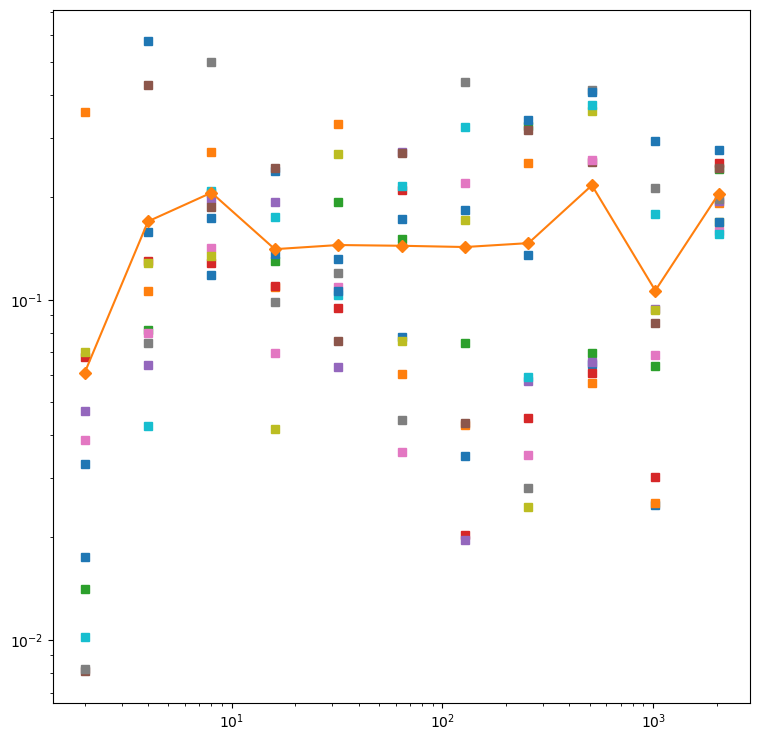

In [8]:
fig, ax = plt.subplots(1,1, figsize=(9,9))

ax.set_xscale("log")
ax.set_yscale("log")

for mpi in mpis
    ax.loglog(df.procs, df[:,mpi], marker="s", linestyle="none")
end

ax.loglog(df.procs, juliampimean, marker="D")

;

In [9]:
function juliafortranmeans(nCellsX, jprocs=1024, fprocs=1024)
    fname = latestfile(CODE_ROOT * "/output/kelvinwave/resolution$(nCellsX)x$(nCellsX)/procs$(jprocs)/steps10/nvlevels100/", x->x[end-3:end] == ".txt")
    # fname *= "2022-08-24T16:27:20.125.txt"
    # fname *= "2022-08-24T16:40:29.640.txt"
    # "/output/kelvinwave/resolution$(nCellsX)x$(nCellsX)/steps10/2022-06-01T20:17:04.919.txt"
    df = DataFrame(CSV.File(fname))
    
    # first sample usually is extreme outlier, might as well skip that one
    runs = filter(col->startswith(col,"sim_time"), names(df))[2:end]
    mpis = filter(col->startswith(col,"mpi_time"), names(df))[2:end]
    juliasimmean = 1/length(runs) * sum(Array(df[:,runs]), dims=2)
    juliampimean = 1/length(mpis) * sum(Array(df[:,mpis]), dims=2)
    juliameans = juliasimmean .+ juliampimean


    fortranfname = latestfile(CODE_ROOT * "/output/kelvinwave/fortranperformance/resolution$(nCellsX)x$(nCellsX)/", x -> occursin("$fprocs", x) && x[end-3:end] == ".txt")
    fortrantiming = readdlm(fortranfname, skipstart=7)
    fortranmeans = fortrantiming[:,end-2] #./ 4
    fortranprocs = fortrantiming[:,1]
    return juliameans, df.procs, fortranmeans, fortranprocs, fname, fortranfname
end

juliafortranmeans (generic function with 3 methods)

In [10]:
function strongscalingplot(juliameans, juliaprocs, fortranmeans, fortranprocs, nCellsX)

    perfectjulia = juliameans[1] * juliaprocs[1] ./ juliaprocs

    
    linewidth = 1
    linestyle = "-"
    markersize = 10
    tickfontsize = 15
    labelfontsize = 22.5
    titlefontsize = 25
    blue = "blue"
    red = "red"

    fig, ax = plt.subplots(figsize=(9,9))
    ax.loglog(juliaprocs, juliameans, label="Julia", linewidth=linewidth,linestyle="-",color=red,marker="s",markersize=markersize)
    ax.loglog(fortranprocs, fortranmeans, label="Fortran", linewidth=linewidth,linestyle="--",color=blue,marker="D",markersize=markersize)
    ax.loglog(juliaprocs, perfectjulia, label="Perfect scaling", linestyle=":", color="black", linewidth=2)


    ax.set_xticks(juliaprocs)
    ax.tick_params(axis="x", labelsize=tickfontsize)
    ax.tick_params(axis="y", labelsize=tickfontsize)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
    ax.set_xlabel("Number of processors", fontsize=labelfontsize, labelpad=10)
    ax.set_ylabel("Wall clock time elapsed during computation (s)", fontsize=labelfontsize, labelpad=10)
    ax.set_title("$(nCellsX)x$(nCellsX) Hexagonal Mesh", fontsize=titlefontsize, fontweight="bold", y=1.02)
    ax.legend(loc="upper right", fontsize=labelfontsize-2.5)

    ax.grid(which="both")
    plt.tight_layout()

    return fig, ax
end

strongscalingplot (generic function with 1 method)

/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/../../output/kelvinwave/resolution128x128/procs2048/steps10/nvlevels100/2022-12-22T12:05:41.110.txt
/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/../../output/kelvinwave/fortranperformance/resolution128x128/cori-haswell_2048_20220906_062417_128x128_halo1_32CoresPerNode.txt
/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/../../output/kelvinwave/resolution256x256/procs2048/steps10/nvlevels100/2022-12-22T12:20:49.804.txt
/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/../../output/kelvinwave/fortranperformance/resolution256x256/cori-haswell_2048_20220905_135505_256x256_halo1_32CoresPerNode.txt
/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/../../output/kelvinwave/resolution512x512/procs2048/steps10/nvlevels100/2022-12-19T14:38:46.917.txt
/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/../../output/kelvinwave/fortranperformance/resolution512x512/cori-

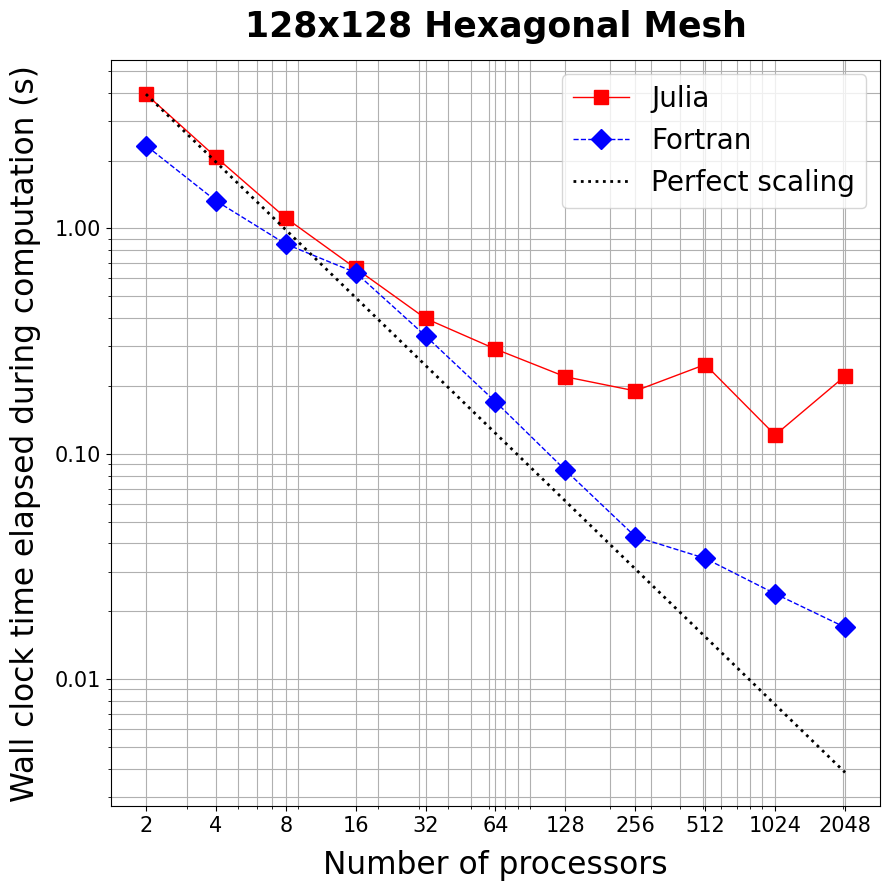

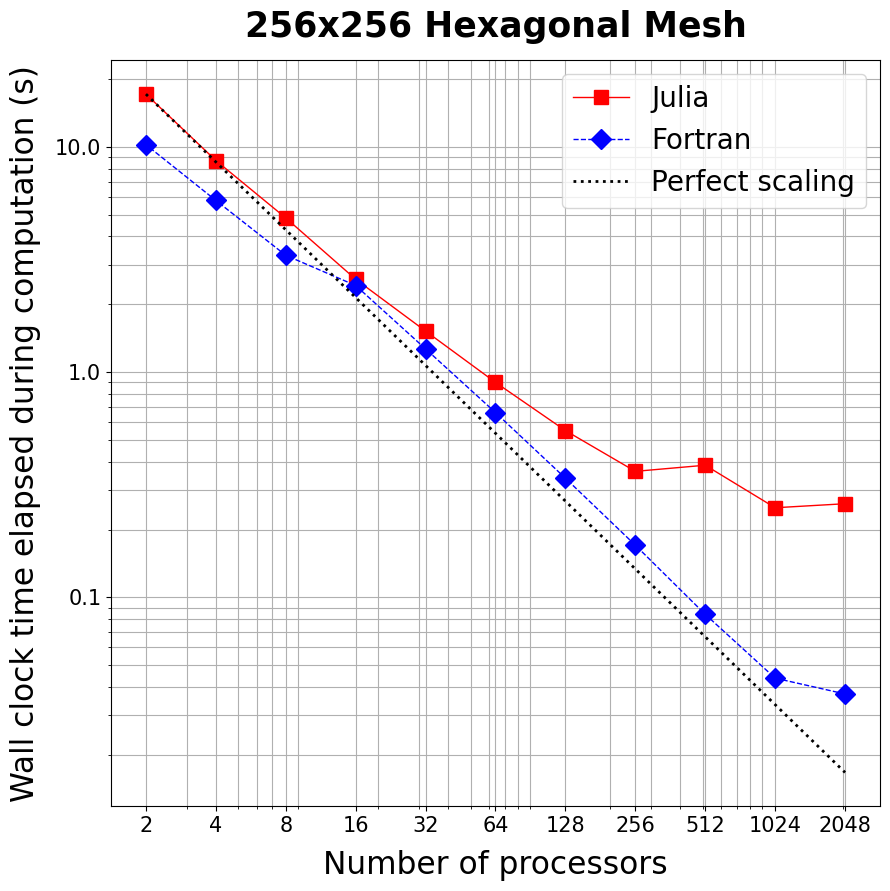

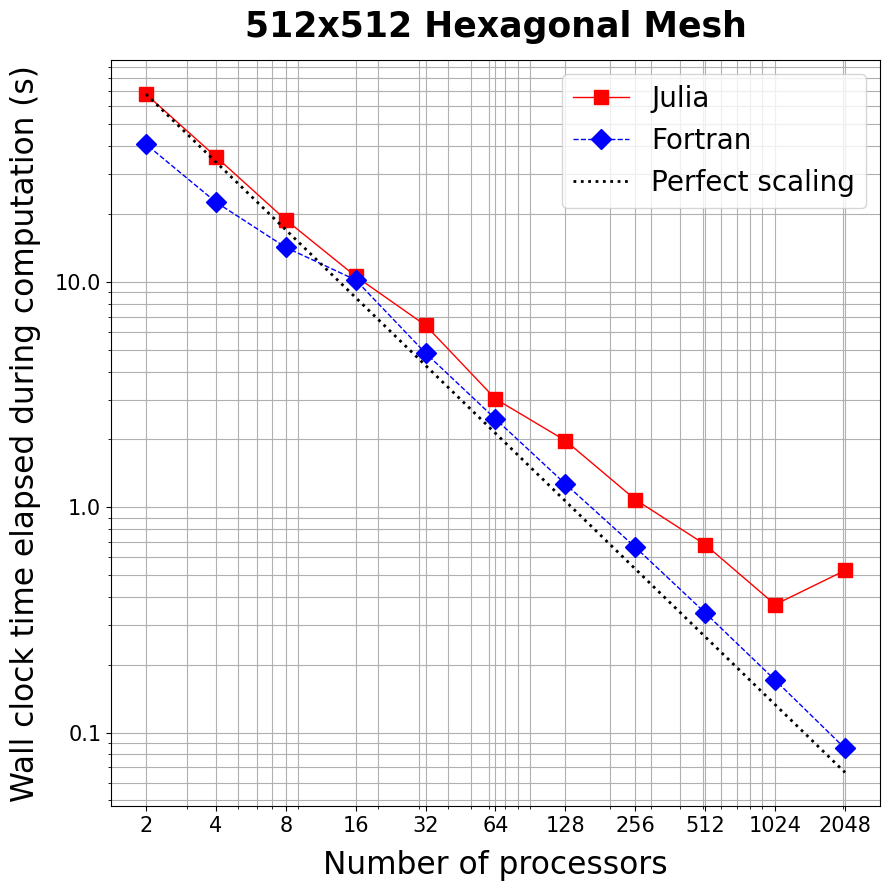

In [12]:
for nCellsX in [128, 256, 512]
    jt, jp, ft, fp, juliafn, fortranfn = juliafortranmeans(nCellsX, 2048, 2048)
    fig, ax = strongscalingplot(jt, jp, ft, fp, nCellsX)
    fig.savefig("$(juliafn)_scaling$(nCellsX)x.pdf")
    println(juliafn)
    println(fortranfn)
end

In [146]:
function strongscalingplot2(julia1, julia1std, julia2, julia2std, juliaprocs, fortran1, fortran2, fortran2std, fortranprocs, nCellsX)

    perfectjulia = (julia2[1] + julia1[1]) * juliaprocs[1] ./ juliaprocs

    linewidth = 1
    linestyle = "-"
    markersize = 10
    tickfontsize = 15
    labelfontsize = 22.5
    titlefontsize = 25
    blue = "blue"
    red = "red"

    fig, ax = plt.subplots(figsize=(9,9))
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.errorbar(juliaprocs, julia1, yerr=julia1std, label="Julia computation", linewidth=linewidth,linestyle="-",color=red,marker="s",markersize=markersize)
    ax.loglog(fortranprocs, fortran1, label="Fortran computation", linewidth=linewidth,linestyle="-",color=blue,marker="D",markersize=markersize)
    
    
    
    ax.errorbar(juliaprocs, julia2, yerr=julia2std, label="Julia communication", linewidth=linewidth,linestyle="--",color=red,marker="P",markersize=markersize)
    ax.loglog(fortranprocs, fortran2, label="Fortran communication", linewidth=linewidth,linestyle="--",color=blue,marker="X",markersize=markersize)
    
    ax.loglog(juliaprocs, perfectjulia, label="Perfect scaling", linestyle=":", color="black", linewidth=2)


    ax.set_xticks(juliaprocs)
    ax.tick_params(axis="x", labelsize=tickfontsize)
    ax.tick_params(axis="y", labelsize=tickfontsize)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    
    ax.set_xlabel("Number of processors", fontsize=labelfontsize, labelpad=10)
    ax.set_ylabel("Wall clock time elapsed during computation (s)", fontsize=labelfontsize, labelpad=10)
    ax.set_title("$(nCellsX)x$(nCellsX) Hexagonal Mesh", fontsize=titlefontsize, fontweight="bold", y=1.02)
    ax.legend(loc="upper right", fontsize=labelfontsize-2.5)

    ax.grid(which="both")
    plt.tight_layout()

    return fig, ax
end

strongscalingplot2 (generic function with 1 method)

/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/../../output/kelvinwave/resolution128x128/procs2048/steps10/nvlevels100/2022-12-22T12:05:41.110.txt
/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/../../output/kelvinwave/resolution256x256/procs2048/steps10/nvlevels100/2022-12-22T12:20:49.804.txt
/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/../../output/kelvinwave/resolution512x512/procs2048/steps10/nvlevels100/2022-12-19T14:38:46.917.txt


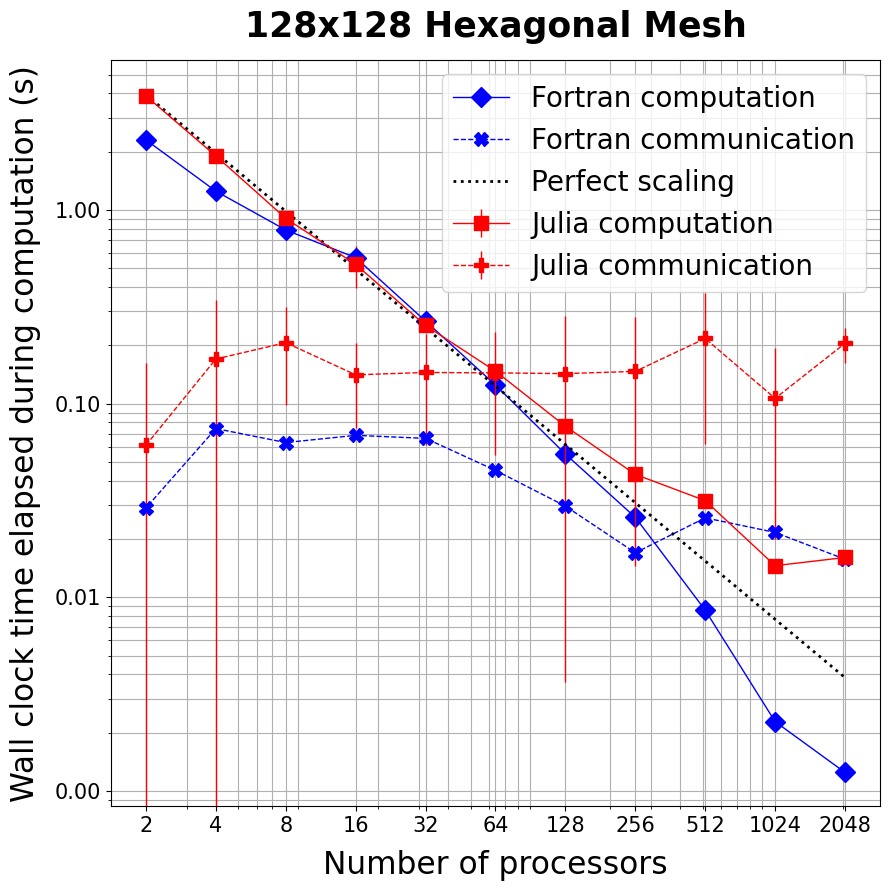

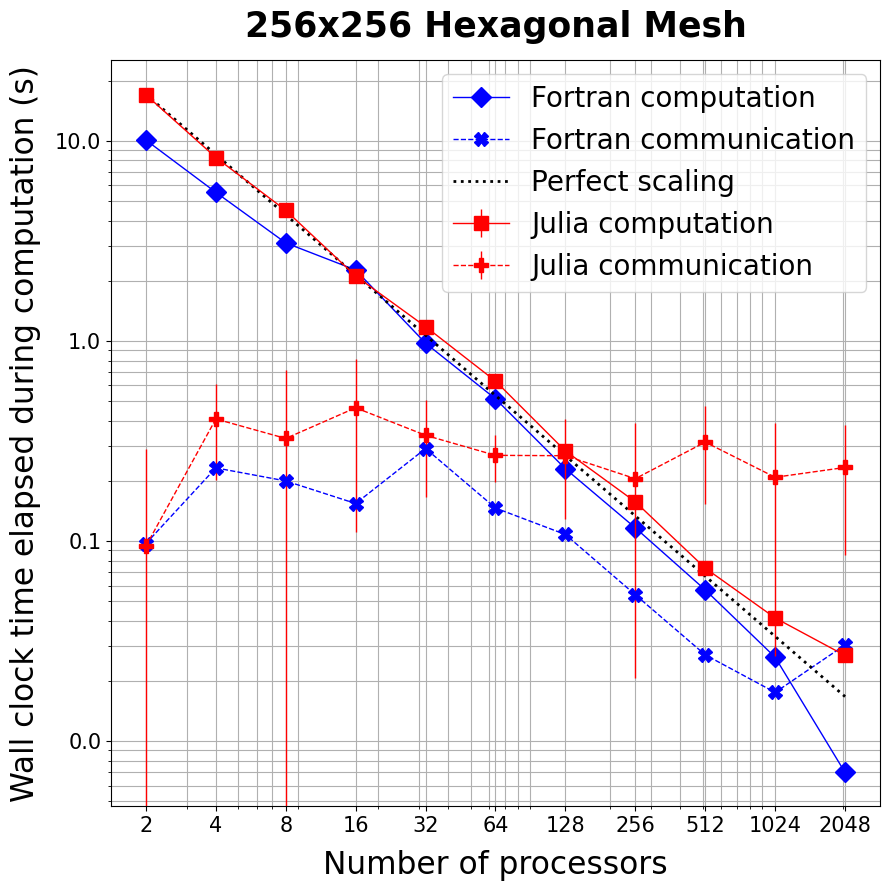

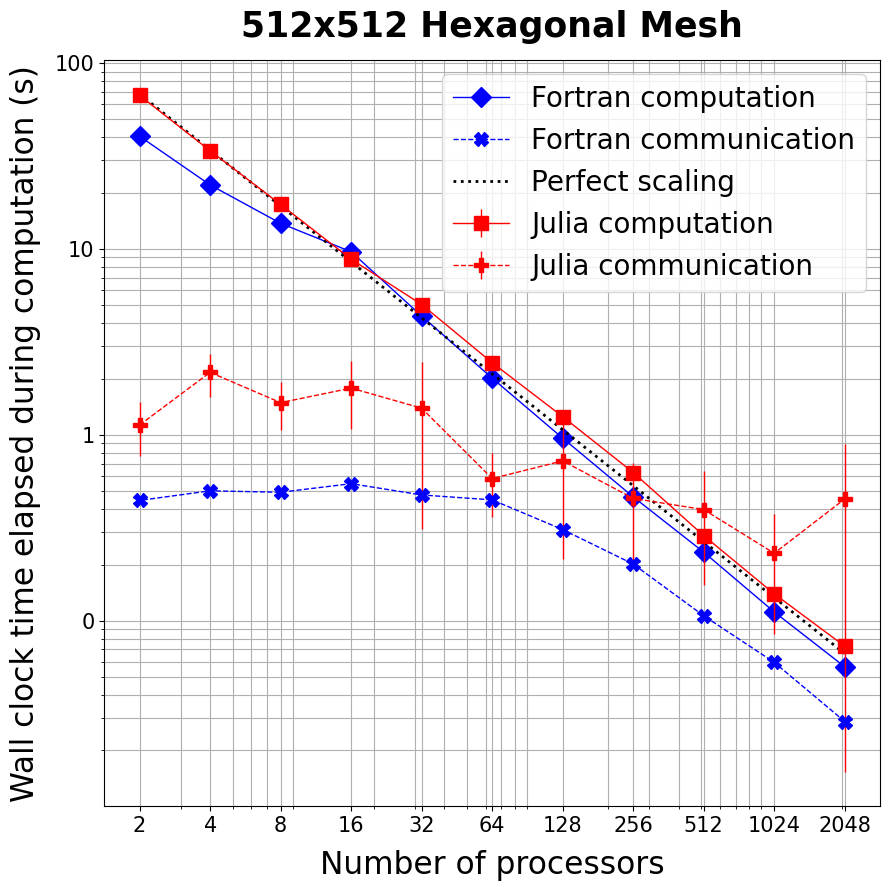

In [148]:
for nCellsX in [128, 256, 512]
    juliasim, juliampi, juliaprocs, fortransim, fortranmpi, fortranprocs, juliafname, fortranfname, juliasimstd, juliampistd = juliafortrantimesplits(nCellsX, 2048, 2048)
    
    fig, ax = strongscalingplot2(juliasim, juliasimstd, juliampi, juliampistd, juliaprocs, fortransim, fortranmpi, zeros(length(fortranprocs)), fortranprocs, nCellsX)
    # fig.text(0.5, 1, "Computation only")
    fig.savefig("$(juliafname)_scaling_$(nCellsX)x_sim_and_mpi.pdf", bbox_inches="tight")
    println(juliafname)
end

In [75]:
function juliafortrantimesplits(nCellsX, jprocs=1024, fprocs=1024)
    fname = latestfile(CODE_ROOT * "/output/kelvinwave/resolution$(nCellsX)x$(nCellsX)/procs$(jprocs)/steps10/nvlevels100/", x->x[end-3:end] == ".txt")
    # fname *= "2022-08-24T16:27:20.125.txt"
    # fname *= "2022-08-24T16:40:29.640.txt"
    # "/output/kelvinwave/resolution$(nCellsX)x$(nCellsX)/steps10/2022-06-01T20:17:04.919.txt"
    df = DataFrame(CSV.File(fname))
    
    # get the simulation time and communication time columns, excluding the first one
    runs = filter(col->startswith(col,"sim_time"), names(df))[2:end]
    mpis = filter(col->startswith(col,"mpi_time"), names(df))[2:end]
    juliasimmean = dropdims( 1/length(runs) * sum(Array(df[:,runs]), dims=2), dims=2)
    # juliampimin = collect([minimum(df[i,mpis]) for i in 1:size(df,1)])
    juliampimean = dropdims( 1/length(mpis) * sum(Array(df[:,mpis]), dims=2), dims=2)
#     juliameans = juliasimmean .+ juliampimean
    juliasimstd = dropdims( std(Array(df[:,runs]), dims=2), dims=2)
    juliampistd = dropdims( std(Array(df[:,mpis]), dims=2), dims=2)
    # juliampidif = juliampimean - juliampimin


    fortranfname = latestfile(CODE_ROOT * "/output/kelvinwave/fortranperformance/resolution$(nCellsX)x$(nCellsX)/", x -> occursin("$fprocs", x) && x[end-3:end] == ".txt")
    fortrantiming = readdlm(fortranfname, skipstart=7)
    fortrantotalmeans = fortrantiming[:,end-2] #./ 4
    fortranhalos = fortrantiming[:,end]
    fortransimmean = fortrantotalmeans - fortranhalos
    # fortransypd = fortrantiming[:,end] .* 4
    fortranprocs = fortrantiming[:,1]
    # factor = ( fortransypd .* fortranmeans )[1]
    return juliasimmean, juliampimean, df.procs, fortransimmean, fortranhalos, fortranprocs, fname, fortranfname, juliasimstd, juliampistd
end

juliafortrantimesplits (generic function with 3 methods)

In [128]:
function timesplitplot(nprocs, comptime, mpitime, nCellsX, info="")
    fontscale = 2
    
    fig, ax = plt.subplots(1,1, figsize=(length(comptime)*3,8))
#     df = DataFrame(processors=nprocs, computation=comptime, communication=mpitime)
#     df.plot(kind="bar", 
#             stacked=true, 
#             colormap="tab10", 
#             figsize=(10, 6))
    totals = comptime + mpitime
    
    ax.bar(string.(Int.(nprocs)), comptime ./ totals, color="blue", label="Computation")
    ax.bar(string.(Int.(nprocs)), mpitime ./ totals, bottom=comptime ./ totals, color="red", label="Communication")
    
    ax.legend(loc="center left", fontsize=20*fontscale, bbox_to_anchor=(1,0.5))
    
    ax.set_yticks([0.0, 0.5, 1.0])
    ax.set_xlabel("Number of processors", fontsize=25*fontscale, labelpad=10.0*fontscale)
    ax.set_ylabel("Proportion of time", fontsize=25*fontscale, labelpad=10.0*fontscale)
    ax.tick_params(axis="x", labelsize=20*fontscale)
    ax.tick_params(axis="y", labelsize=20*fontscale)
    
    # " using $(nCellsX)x$(nCellsX) Hexagonal Mesh"
    ax.set_title("$info: Proportion of Simulation Time \nSpent on Computation and Communication", fontweight="bold", fontsize=30*fontscale, y=1.08)
    
#     plt.tick_params(top="off", bottom="off", left="off", right="off", labelleft="off", labelbottom="on")
    
    # plt.tight_layout()
    
    return fig, ax
end

timesplitplot (generic function with 2 methods)

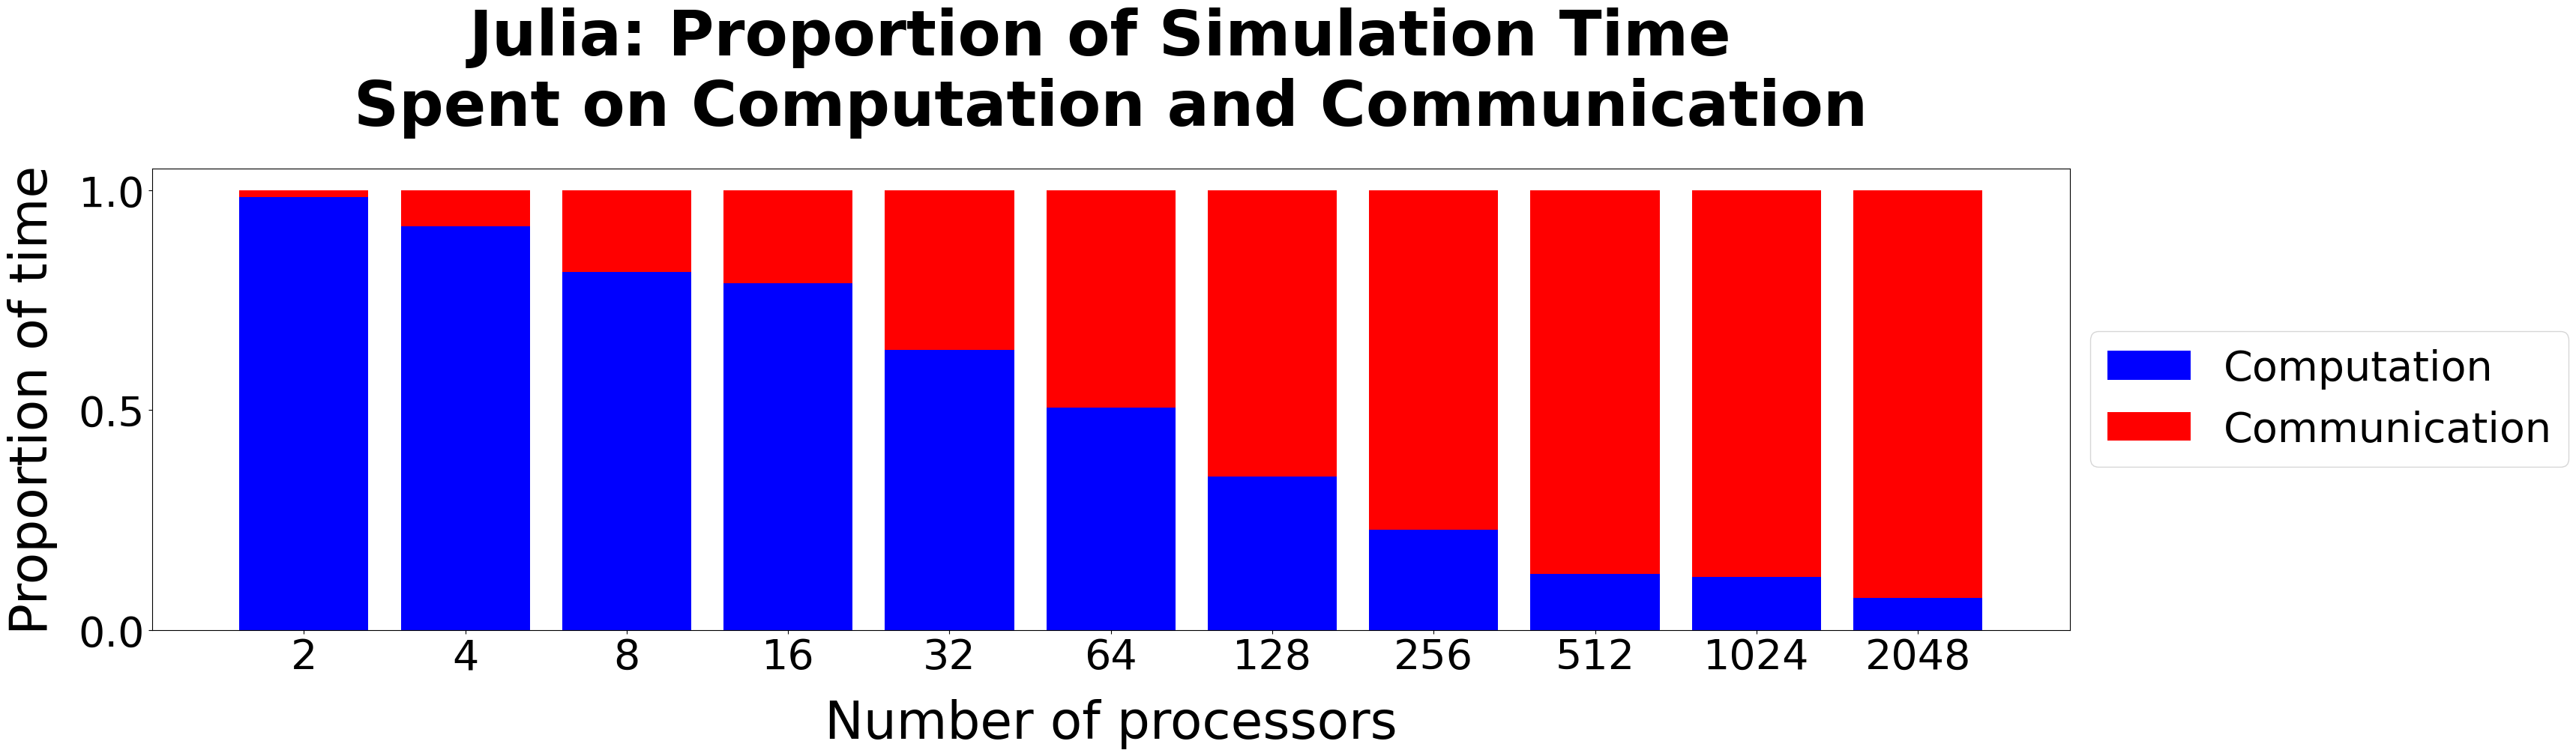

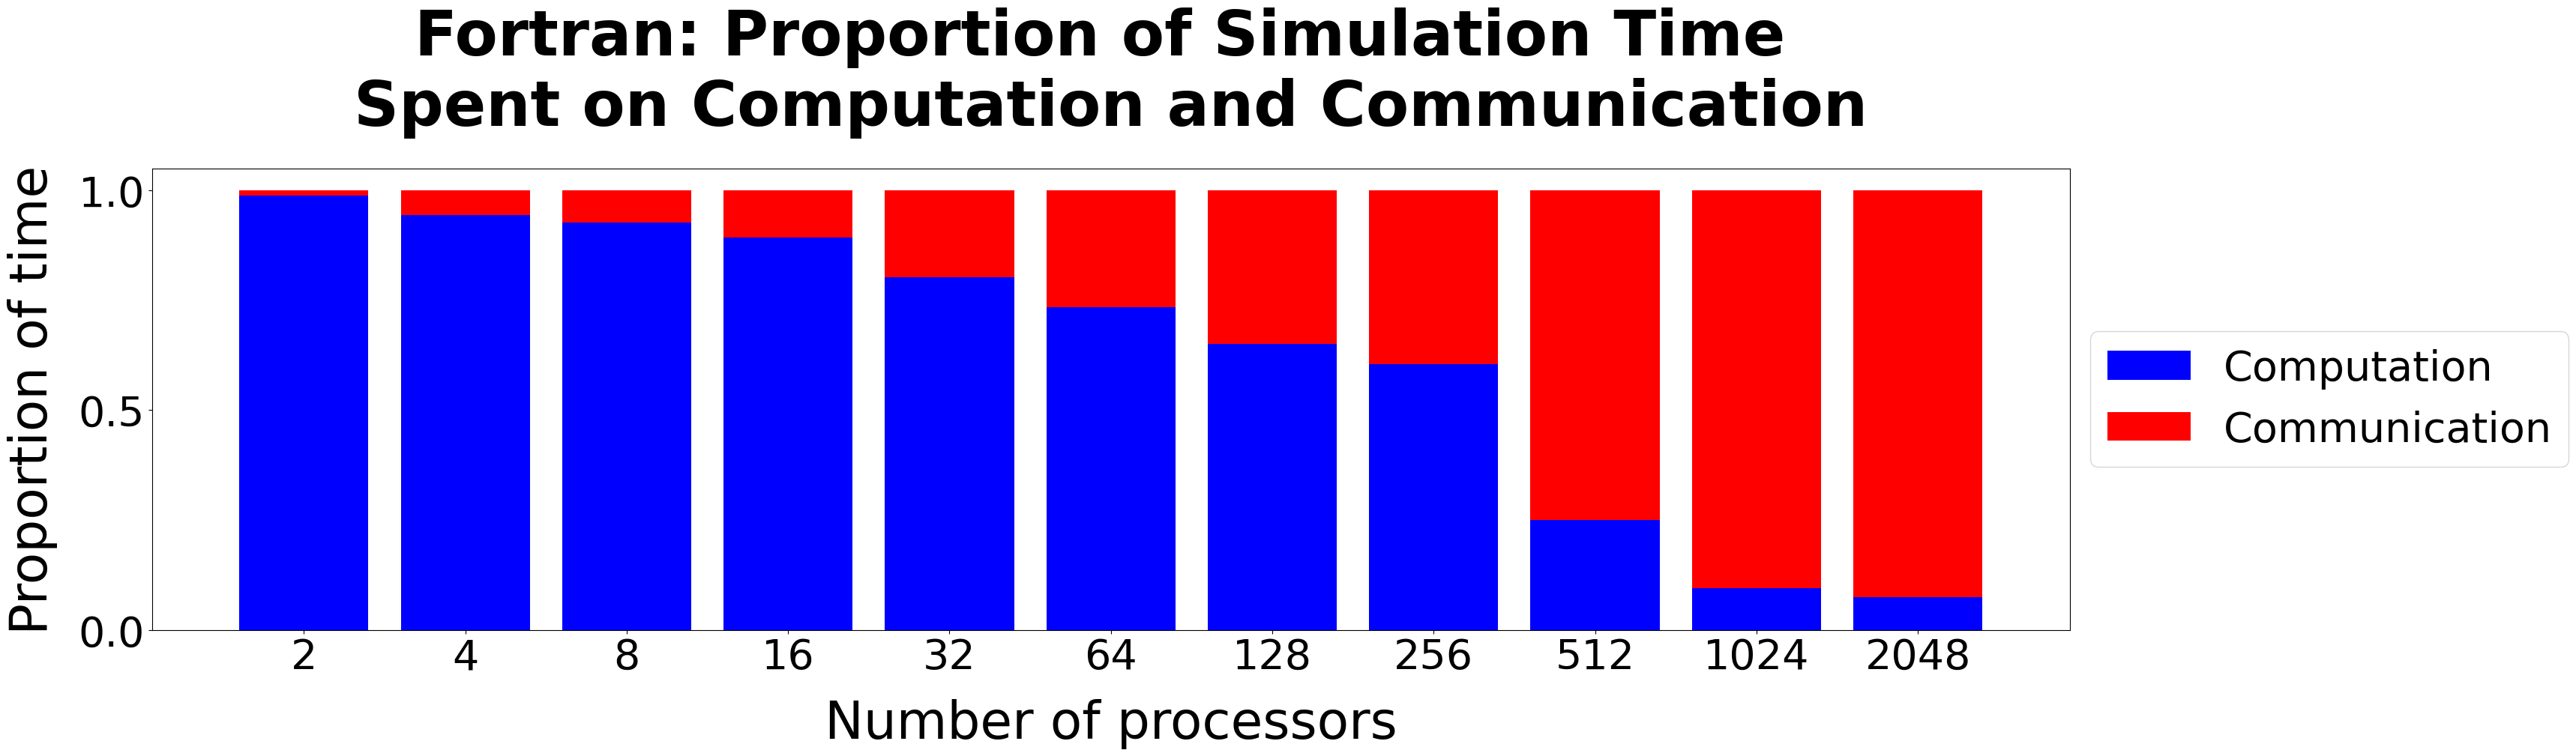

In [129]:
nCellsX = 128
juliasim, juliampi, juliaprocs, fortransim, fortranmpi, fortranprocs, juliafname, fortranfname, juliasimstd, juliampistd = juliafortrantimesplits(nCellsX, 2048, 2048)

fig, ax = timesplitplot(juliaprocs, juliasim, juliampi, nCellsX, "Julia")
fig.savefig("$(juliafname)_proportion_sim_mpi.pdf", bbox_inches="tight")
fig, ax = timesplitplot(fortranprocs[end:-1:1], fortransim[end:-1:1], fortranmpi[end:-1:1], nCellsX, "Fortran")
fig.savefig("$(fortranfname)_proportion_sim_mpi.pdf", bbox_inches="tight")

In [13]:
juliafname

"/global/u2/r/rstrauss/repos/MPAS_Ocean_Julia/output/kelvinwave/../../output/kelvinwave/resolution128x128/procs2048/steps10/nvlevels100/2022-09-06T22:17:58.045.txt"

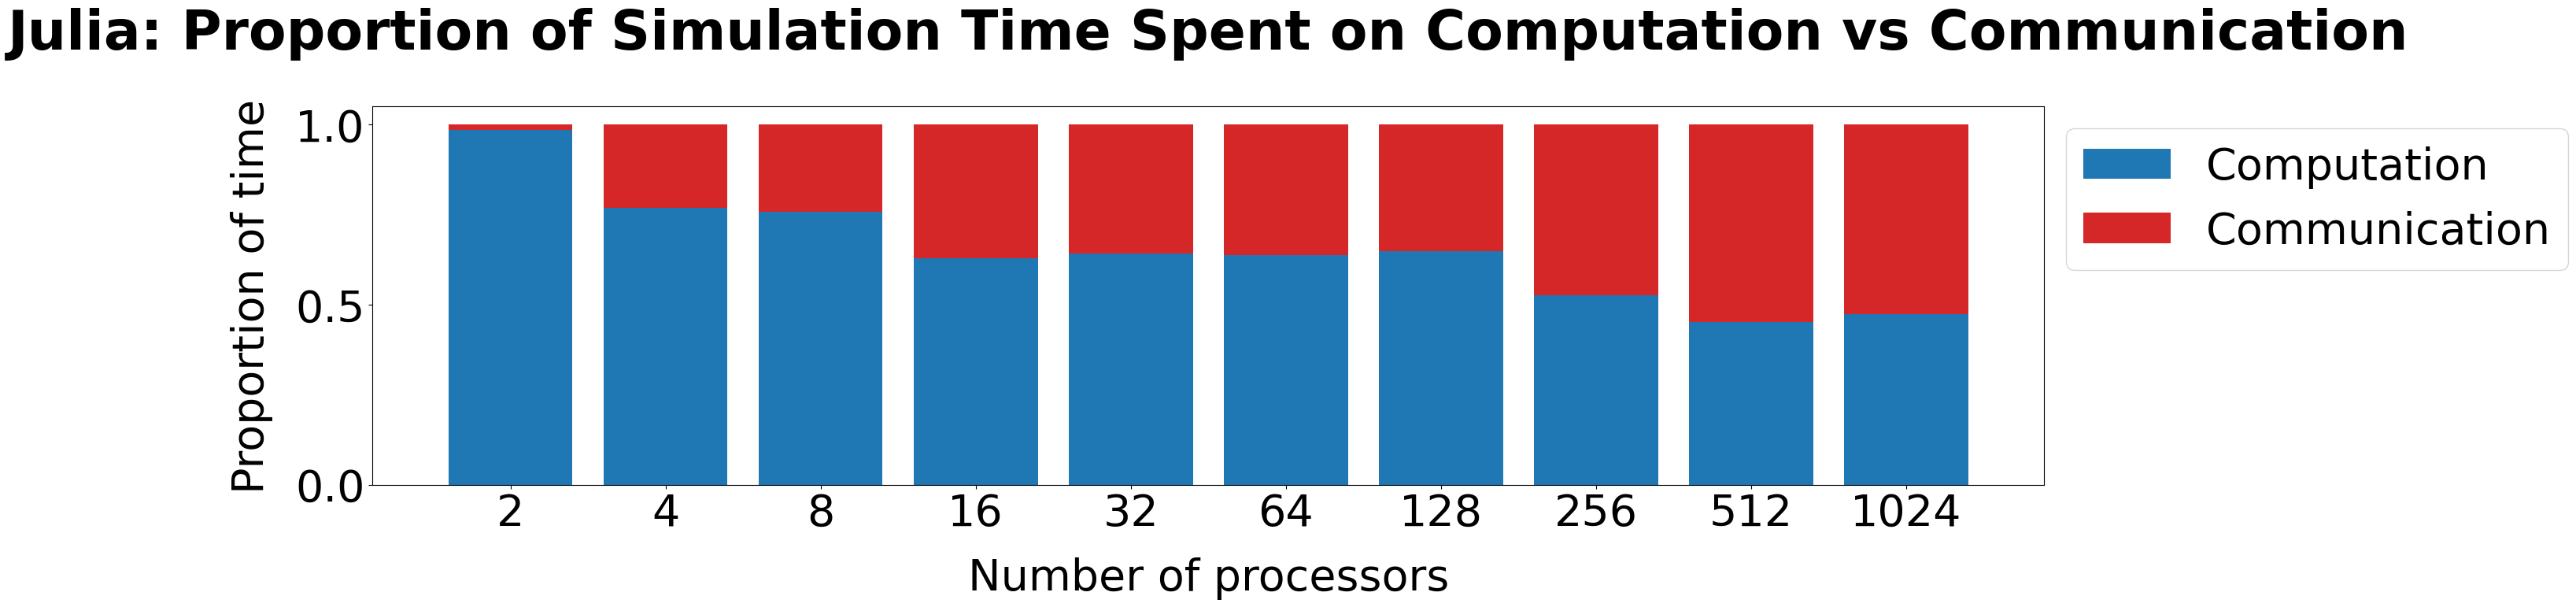

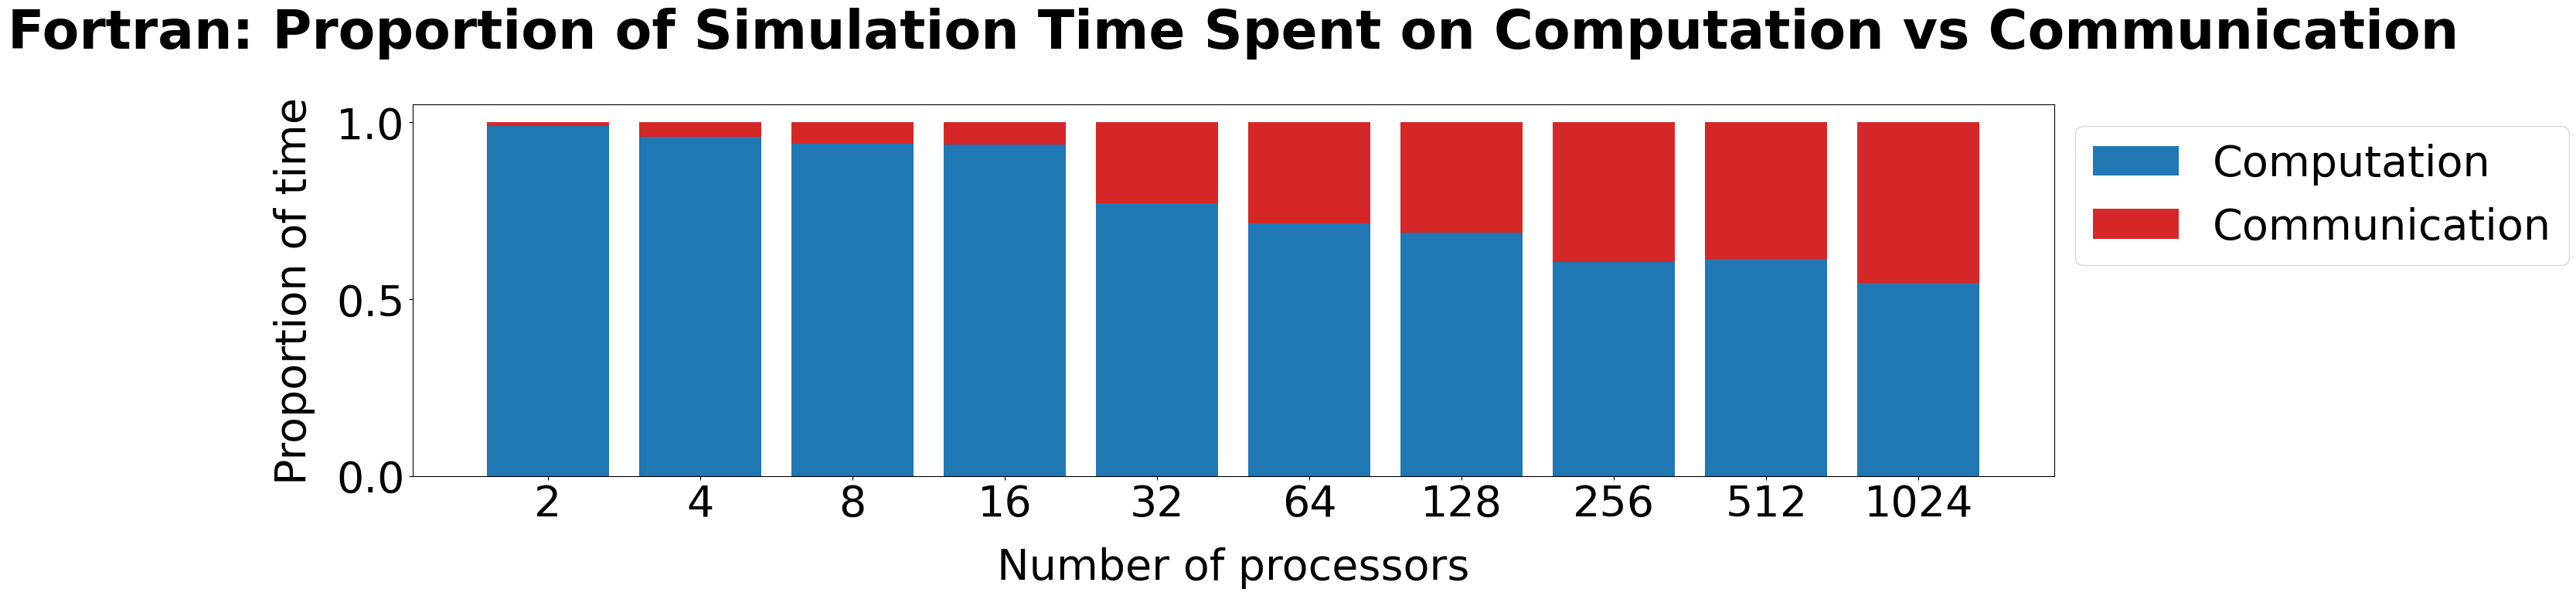

(Figure(PyObject <Figure size 3000x800 with 1 Axes>), PyObject <AxesSubplot: title={'center': 'Fortran: Proportion of Simulation Time Spent on Computation vs Communication'}, xlabel='Number of processors', ylabel='Proportion of time'>)

In [14]:
nCellsX = 256
juliasim, juliampi, juliaprocs, fortransim, fortranmpi, fortranprocs, juliafname, fortranfname = juliafortrantimesplits(nCellsX, 1024, 4096)
fig, ax = timesplitplot(juliaprocs, juliasim, juliampi, nCellsX, "Julia")
# fig.savefig("$(juliafname)_proportion_sim_mpi.pdf")
fig, ax = timesplitplot(fortranprocs[end:-1:3], fortransim[end:-1:3], fortranmpi[end:-1:3], nCellsX, "Fortran")
# fig.savefig("$(fortranfname)_proportion_sim_mpi.pdf")

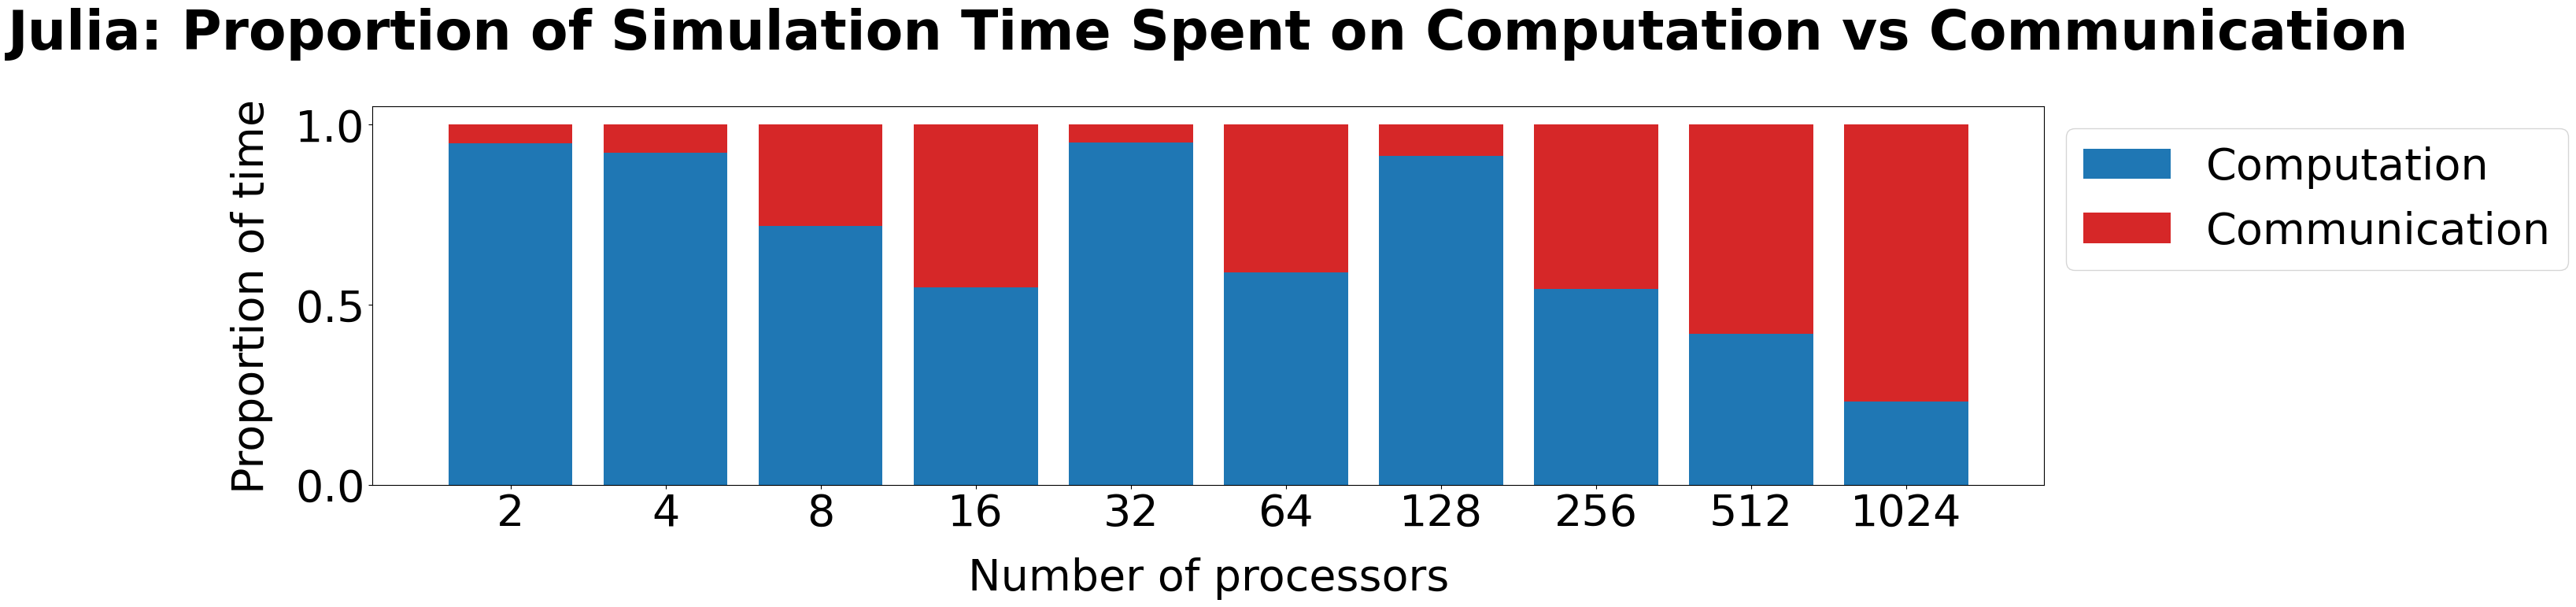

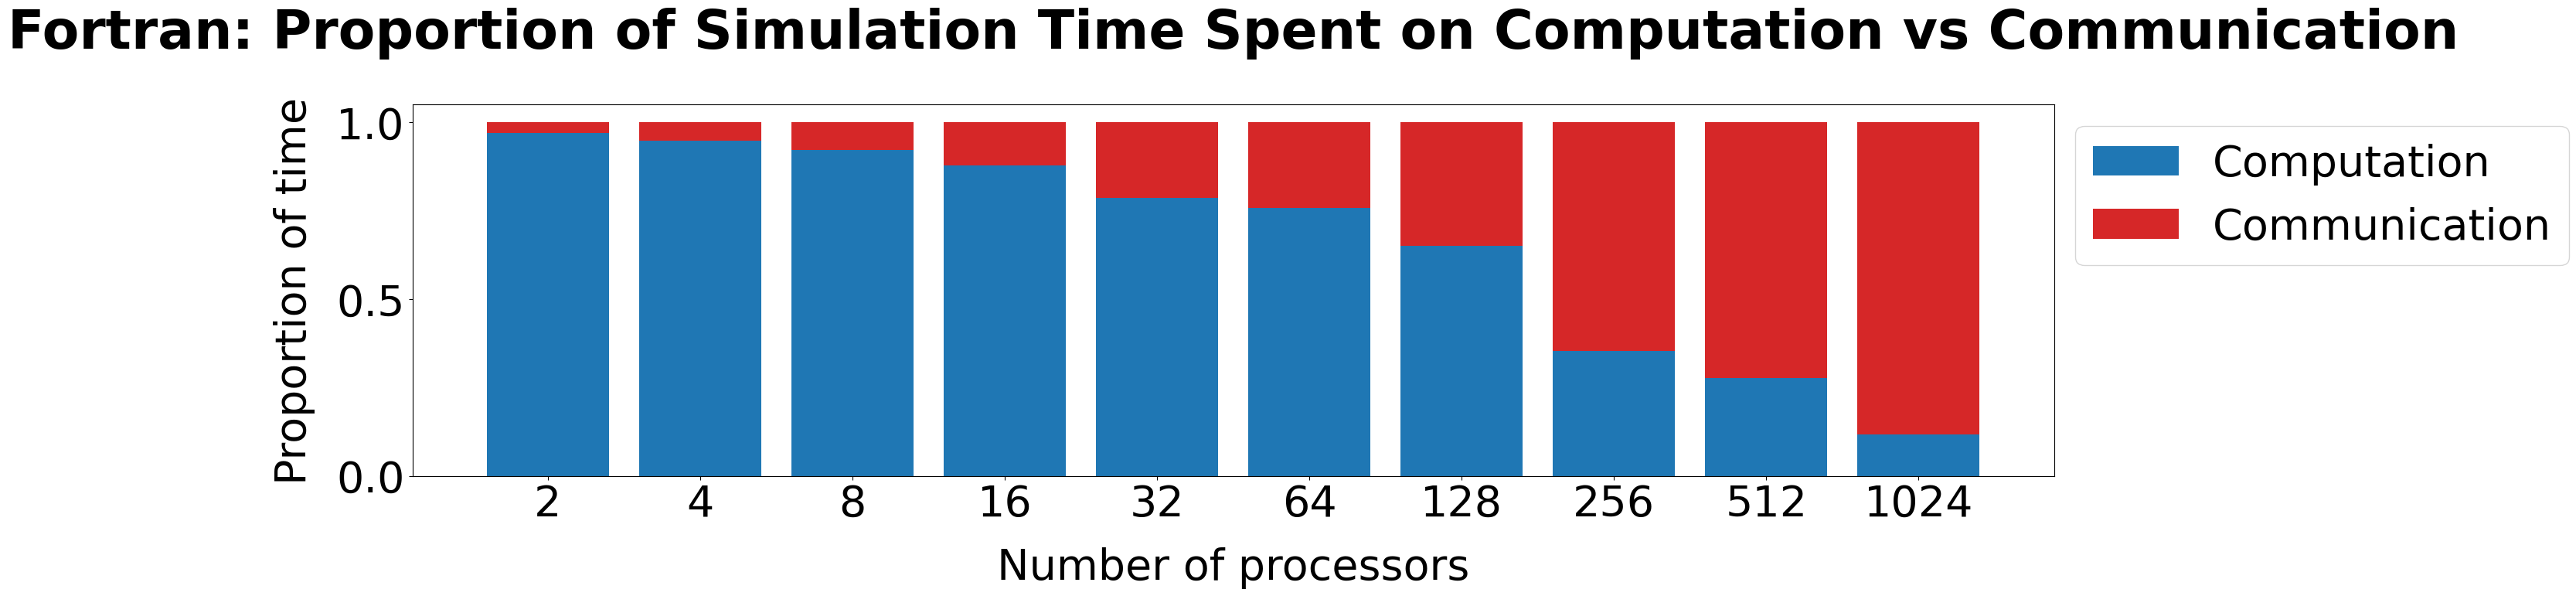

In [8]:
nCellsX = 128
juliasim, juliampi, juliaprocs, fortransim, fortranmpi, fortranprocs, juliafname, fortranfname = juliafortrantimesplits(nCellsX, 1024, 4096)
fig, ax = timesplitplot(juliaprocs, juliasim, juliampi, nCellsX, "Julia")
# fig.savefig("$(juliafname)_proportion_sim_mpi.pdf")
fig, ax = timesplitplot(fortranprocs[end:-1:3], fortransim[end:-1:3], fortranmpi[end:-1:3], nCellsX, "Fortran")
# fig.savefig("$(fortranfname)_proportion_sim_mpi.pdf")

In [ ]:
function weakscalingplot()
    resolutions = [128, 256, 512]
    cellsperproclines = [64^2, 64^2 /2, 64^2/4]
    juliatimes = zeros((length(resolutions),length(cellsperproclines)))
    fortrantimes = zeros((length(resolutions),length(cellsperproclines)))
    fnames = Vector{String}(undef, 4)

    for (i, nCellsX) in enumerate(resolutions)
        juliameans, juliaprocs, fortranmeans, fortranprocs, fnames[i] = juliafortranmeans(nCellsX)

        ind = findall(cpp -> cpp in cellsperproclines, nCellsX^2 ./ juliaprocs)
        juliatimes[i,:] = juliameans[ind]

        ind = findall(cpp -> cpp in cellsperproclines, nCellsX^2 ./ fortranprocs)
        fortrantimes[i,:] = fortranmeans[ind]
    end

    fig, ax = plt.subplots(1,1, figsize=(9,9))

    julialines = ax.loglog(resolutions, juliatimes)
    fortranlines = ax.loglog(resolutions, fortrantimes, linestyle="--")
    ax.set_xlabel("Number of cells (X)")
    ax.set_ylabel("Wallclock time elapsed during computation")
    ax.legend(julialines, cellsperproclines, title="cells per process (julia)", loc="upper left")
    ax.legend(fortranlines, cellsperproclines, title="cells per process (fortran)", loc="upper right")

    display(fig)

    return fig
end

weakscalingplot()





# fig.savefig("/tmp/plot.png")